In [1]:
import autograd.numpy as np
from autograd import grad, hessian
from autograd import elementwise_grad
from scipy.optimize import fmin_l_bfgs_b, fmin_bfgs, fmin_cg, fmin_ncg
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve, cholesky
from autograd.scipy.linalg import solve_triangular
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.linear_model import LogisticRegression
from autograd.misc.optimizers import adam
import copy
import glob
import imageio
import skimage
from skimage import data, io, filters



In [3]:
img_arr = np.array([skimage.img_as_float(imageio.imread(file)) for file in glob.glob('yale/*png')])
img_arr_rescaled = np.array([skimage.img_as_float(skimage.transform.rescale(imageio.imread(file),1.0 / 4.0)) for file in glob.glob('yale/*png')])

In [4]:
x = np.reshape(img_arr_rescaled, (img_arr_rescaled.shape[0], img_arr_rescaled.shape[1]*img_arr_rescaled.shape[2]))

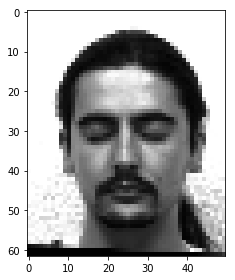

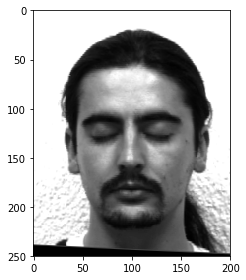

In [5]:
skimage.io.imshow(img_arr_rescaled[0])
skimage.io.show()
skimage.io.imshow(img_arr[0])
skimage.io.show()

In [6]:
y = np.zeros(x.shape[0])
for i in range(x.shape[0]):
    if any(s in glob.glob('yale/*png')[i] for s in ('sad', 'wink', 'surprised', 'sleepy', 'happy')):
        y[i] = 1
    

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def objective_logit (params, x, y, latent_dim, lambda_e, opt): #check the order of arguments!
    N = x.shape[0]
    D = x.shape[1]
    f, bias_x, cov_noise, w = decode_parameters(params, D, latent_dim, opt)
        
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    #print cov_x.shape
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    #print log_det_cov_x
    temp1 = np.linalg.solve(cov_x, (x - bias_x).T)
    unnorm_log_pdf_x = np.einsum("nd,dn->n", x - bias_x, temp1)
    
    mean_z = np.einsum("dl,dn->nl", f, temp1)
    temp2 = np.einsum("l,nl->n", w[1:], mean_z) + w[0]
    log_bern_pdf_y = np.log(sigmoid(np.multiply((2*y-1),temp2)))
    log_prior = 0 
    lambda_r = 1
    reg1 = lambda_r*np.sum(f**2)
    reg2 = lambda_r*np.sum(w**2)
    reg = reg1+reg2
    ll = N*D*np.log(2*np.pi)/2 + log_det_cov_x*0.5*N + np.sum(unnorm_log_pdf_x)*0.5 
    ll = ll - lambda_e*np.sum(log_bern_pdf_y) - log_prior + reg
    return ll

def objective_logit_fast(params, x, y, latent_dim, lambda_e, opt): #check the order of arguments!
    N = x.shape[0]
    D = x.shape[1]
    f, bias_x, cov_noise, w = decode_parameters_fast(params, D, latent_dim, opt)
    L = f.shape[1]
        
    icn = (1.0 / cov_noise).reshape((-1, 1))
    xn = (x - bias_x).T
    Ax = icn * xn
    Au = icn * f
    C = np.eye(L) + np.dot(f.T, Au)
    temp1 = np.dot(f.T, Ax)
    temp1 = np.linalg.solve(C, temp1)
    temp1 = np.dot(Au, temp1)
    temp1 = Ax - temp1
    sign, log_det_cov_x = np.linalg.slogdet(C)
    log_det_cov_x += np.sum(np.log(cov_noise))
    
    unnorm_log_pdf_x = np.einsum("dn,dn->n", xn, temp1)
    
    mean_z = np.dot(f.T, temp1).T
    temp2 = np.einsum("l,nl->n", w[1:], mean_z) + w[0]
    log_bern_pdf_y = np.log(sigmoid(np.multiply((2*y-1),temp2)))
    log_prior = 0 
    lambda_r = 1
    reg1 = lambda_r*np.sum(f**2)
    reg2 = lambda_r*np.sum(w**2)
    reg = reg1+reg2
    ll = N*D*np.log(2*np.pi)/2 + log_det_cov_x*0.5*N + np.sum(unnorm_log_pdf_x)*0.5 
    ll = ll - lambda_e*np.sum(log_bern_pdf_y) - log_prior + reg
    return ll

def decode_parameters_fast(params, D, latent_dim, opt):
    size_f = D*latent_dim
    f =  params[:size_f]
    #f = f*np.array([0,1]) + np.array([1,0])
    f =  f.reshape(D, latent_dim)
    bias_x = params[size_f:size_f+D]
    if (opt=="ppca"):
        var = params[size_f+D]
        cov_noise= np.ones(D)*np.log(1+np.exp(var))
        #cov_noise= np.diag(np.ones(D)*np.exp(var))
        w = params[size_f+D+1:]
    else:
        var = params[size_f+D:size_f+D*2]
        cov_noise = np.log(1+np.exp(var))
        w = params[size_f+D*2:]
    return f, bias_x, cov_noise, w

def decode_parameters(params, D, latent_dim, opt):
    size_f = D*latent_dim
    f =  params[:size_f]
    #f = f*np.array([0,1]) + np.array([1,0])
    f =  f.reshape(D, latent_dim)
    bias_x = params[size_f:size_f+D]
    if (opt=="ppca"):
        var = params[size_f+D]
        cov_noise= np.diag(np.ones(D)*np.log(1+np.exp(var)))
        #cov_noise= np.diag(np.ones(D)*np.exp(var))
        w = params[size_f+D+1:]
    else:
        var = params[size_f+D:size_f+D*2]
        cov_noise= np.diag(np.log(1+np.exp(var)))
        w = params[size_f+D*2:]
    return f, bias_x, cov_noise, w

def transform(f, bias, cov_noise, x):
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    temp = np.linalg.solve(cov_x, (x - bias).T)
    mean_z = np.einsum("dl,dn->nl", f, temp)
    return mean_z

def compute_ll(f,bias,cov_noise, x):
    N = x.shape[0]
    D = x.shape[1]
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    temp1 = np.linalg.solve(cov_x, (x - bias).T)
    ll = N*D*np.log(2*np.pi)/2
    ll += log_det_cov_x*N/2
    ll += np.sum(np.einsum("nd,dn->n", x - bias, temp1))/2
    return -ll

def compute_pl_logit(f, bias_x, cov_noise, w, x, y):
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    temp1 = np.linalg.solve(cov_x, (x - bias_x).T)
    mean_z = np.einsum("dl,dn->nl", f, temp1)
    temp2 = np.einsum("l,nl->n", w[1:], mean_z) + w[0]
    log_bern_pdf_y = np.log(sigmoid(np.multiply((2*y-1),temp2)))
    return np.sum(log_bern_pdf_y)

In [8]:
latent_dim = 10
x_dim = x.shape[1]      
size_f = latent_dim*x_dim

params_size_logit_fa = x_dim*latent_dim + x_dim + x_dim + latent_dim + 1
params_size_norm_fa = x_dim*latent_dim + x_dim + x_dim + latent_dim
params_size_logit_ppca = x_dim*latent_dim + x_dim + 1 + latent_dim + 1
params_size_norm_ppca = x_dim*latent_dim + x_dim + 1 + latent_dim 

In [9]:
opt = "ppca"
if (opt == "fa"):
    params_size = params_size_logit_fa
else:
    params_size = params_size_logit_ppca

In [11]:
transformer = PCA(latent_dim)
x_proj_fa_python = transformer.fit_transform(x)
clf_pc = LogisticRegression().fit(x_proj_fa_python, y)
acc_score_PCA = clf_pc.score(x_proj_fa_python, y)
acc_score_PCA

/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6923076923076923

In [12]:
f_sklearn = transformer.components_.T
cov_noise_sklearn = np.diag(np.ones(x_dim)*transformer.noise_variance_)
bias_sklearn = np.mean(x, axis = 0)
print "F sklearn", f_sklearn 
print "mean of x \n", bias_sklearn 
print "cov noise sklearn\n", cov_noise_sklearn 


F sklearn [[-0.05352978 -0.01183125  0.01351826 ... -0.04342104 -0.00484463
  -0.00221695]
 [-0.05396946 -0.01230747  0.01392893 ... -0.04097783 -0.00231261
  -0.00433192]
 [-0.05462667 -0.01235068  0.01431891 ... -0.0375067   0.0004354
  -0.00706014]
 ...
 [ 0.0016976  -0.00677717 -0.02009347 ... -0.05666387 -0.02175006
  -0.00760717]
 [ 0.0019807  -0.00753482 -0.02080055 ... -0.05893058 -0.02140983
  -0.00493557]
 [ 0.00062577 -0.00838688 -0.021237   ... -0.06106277 -0.01899631
  -0.00371998]]
mean of x 
[0.57445628 0.57190191 0.56815939 ... 0.22782222 0.23819053 0.24549847]
cov noise sklearn
[[0.5025056 0.        0.        ... 0.        0.        0.       ]
 [0.        0.5025056 0.        ... 0.        0.        0.       ]
 [0.        0.        0.5025056 ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.5025056 0.        0.       ]
 [0.        0.        0.        ... 0.        0.5025056 0.       ]
 [0.        0.        0.        ... 0.        0.        0.

In [14]:
init_params = np.random.rand(params_size)
f, bias, cov_noise, w =  decode_parameters(init_params, x_dim, latent_dim, opt)
print "Initial parameters"
print "F:", f
print "slope", f[1]/f[0]
print "bias: ", bias
print "cov_noise matrix: ", cov_noise
print "bias for y:\n", w[0]
print "logistic regression weights:\n", w[1:]
print "initial obj value logit", objective_logit_fast(init_params, x, y, latent_dim, 0, opt)


Initial parameters
F: [[0.94903956 0.88957692 0.44880554 ... 0.29250742 0.23226564 0.84808443]
 [0.83386066 0.69893692 0.07828689 ... 0.09905412 0.40874377 0.59840882]
 [0.14090813 0.01934814 0.51007399 ... 0.10680792 0.68298492 0.0622228 ]
 ...
 [0.47416754 0.36795772 0.93172745 ... 0.22883504 0.11976115 0.62384486]
 [0.84725574 0.8018552  0.47542771 ... 0.86315223 0.05567995 0.90569498]
 [0.15870712 0.44364662 0.06630008 ... 0.4059113  0.85897252 0.39256794]]
slope [0.87863636 0.78569588 0.17443387 1.37758761 2.15113511 2.5959776
 4.69405761 0.33863799 1.7598116  0.70560053]
bias:  [0.1770812  0.61101757 0.83381793 ... 0.86637841 0.34360715 0.50400031]
cov_noise matrix:  [[1.27371338 0.         0.         ... 0.         0.         0.        ]
 [0.         1.27371338 0.         ... 0.         0.         0.        ]
 [0.         0.         1.27371338 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.27371338 0.         0.        ]
 [0.         0.      

In [15]:
grad_objective_logit = grad(objective_logit, argnum = 0)
grad_objective_logit_fast = grad(objective_logit_fast, argnum = 0)
#%lprun -f objective_logit_fast objective_logit_fast(init_params, x, y, latent_dim, 10, opt)

#%timeit grad_objective_logit_fast(init_params, x, y, latent_dim, 10, opt)
#%timeit grad_objective_logit(init_params, x, y, latent_dim, 10, opt)
#%timeit grad_objective_logit(init_params, x, y, latent_dim, 10, opt)

In [16]:
%timeit objective_logit(init_params, x, y, latent_dim, 10, opt)
%timeit grad_objective_logit_fast(init_params, x, y, latent_dim, 10, opt)


1 loop, best of 3: 953 ms per loop
10 loops, best of 3: 40.6 ms per loop


In [17]:
params_optimizied_logit, obj, dict = fmin_l_bfgs_b(objective_logit_fast, x0 = init_params, fprime = grad_objective_logit_fast, args = (x, y, latent_dim, 10000, opt))#, callback=callback)

In [18]:
f_logit, bias_logit, cov_noise_logit, w_logit = decode_parameters(params_optimizied_logit, x_dim, latent_dim, opt)
x_proj_logit = transform(f_logit, bias_logit, cov_noise_logit, x)
clf_pc = LogisticRegression().fit(x_proj_logit, y)
print clf_pc.score(x_proj_logit, y)
print compute_ll(f_logit, bias_logit, cov_noise_logit, x)
print  obj
print compute_pl_logit(f_logit, bias_logit, cov_noise_logit, w_logit, x, y) 


1.0
209618.04944460117
-208667.03751869276
-0.017130134045388032


In [19]:
clf_orig = LogisticRegression().fit(x, y)
print clf_orig.score(x, y)

1.0


In [32]:
batch_size = 10
max_epoch = 100
step_size = 0.001

num_batches = int(np.ceil(x.shape[0]/batch_size))
num_iters = num_batches*max_epoch

def batch_indices(i):
    idx = i % num_batches
    return slice(idx * batch_size, (idx+1) * batch_size)

def get_grad_obj(params, x, y, latent_dim, lambda_e, opt, batch_idx):
    def opt_objective(params, batch_idx):
        idx = batch_indices(batch_idx)
        return objective_logit_fast(params, x[idx], y[idx], latent_dim, lambda_e, opt)
    return grad(opt_objective)

In [33]:
lambda_e = 10000

print("     Epoch     |    Obj value     |    Train accuracy")
def print_perf(params, iter, gradient):
    if iter % num_batches == 0:
        obj_val = objective_logit_fast(params, x, y, latent_dim, lambda_e, opt)
        f, bias, cov_noise, w =  decode_parameters(params, x_dim, latent_dim, opt)
        x_proj_logit_adam = transform(f, bias, cov_noise, x)
        clf_pc = LogisticRegression().fit(x_proj_logit_adam, y)
        train_acc = clf_pc.score(x_proj_logit_adam, y)
        print("{:15}|{:20}|{:20}".format(iter//num_batches, obj_val, train_acc))

params_opt_adam_logit = adam(get_grad_obj(init_params, x, y, latent_dim, lambda_e, opt, iter), init_params, step_size = step_size,  callback=print_perf, num_iters=num_iters)

f, bias, cov_noise, w =  decode_parameters(params_opt_adam_logit, x_dim, latent_dim, opt)
x_proj_logit_adam = transform(f, bias, cov_noise, x)
clf_pc = LogisticRegression().fit(x_proj_logit_adam, y)
train_acc = clf_pc.score(x_proj_logit_adam, y)
print train_acc

     Epoch     |    Obj value     |    Train accuracy
              0|        1390010.8395|      0.569230769231
              1|       1381904.57127|      0.576923076923
              2|       1372497.03697|      0.592307692308
              3|       1364130.67211|      0.615384615385
              4|        1356700.1381|      0.630769230769
              5|        1350106.0684|      0.638461538462
              6|       1344226.87886|      0.646153846154
              7|       1338898.59369|      0.646153846154
              8|       1333931.30356|      0.623076923077
              9|       1329143.27439|      0.607692307692
             10|       1324386.82127|      0.623076923077
             11|       1319554.85897|      0.615384615385
             12|       1314573.30976|      0.615384615385
             13|        1309389.2393|      0.615384615385
             14|       1303961.00923|      0.607692307692
             15|       1298252.06174|      0.623076923077
             16|  